# Import template 


In [8]:
%run Template.ipynb

In [9]:
isCollab = False
pathLogMel = "npy/"
pathDriveSaveFile = "models_save/"

if isCollab:
    pathLogMel = "/content/drive/MyDrive/Datascience projet son/LogMel/"
    pathDriveSaveFile = "/content/drive/MyDrive/Datascience projet son/You/Auto_save_AE_"

# Definition Path Fichier & Variable

In [ ]:
#chargement des modèles pré-entrainés
# autoencoder3D = keras.models.load_model("autoencoder3D_0506_fan_256dt_600E.joblib")
# autoencoderV2=keras.models.load_model("AE_V2.joblib")
# AE_DENSE_JAP=keras.models.load_model("AE_DENSE_JAP_427_320.joblib")
AE_slider=keras.models.load_model("Auto_save_AE_slider.hdf5")

In [10]:
# IMPORT DES FICHIERS
freq=256
dt=256
normal_val=0
anomaly_val=1

machine='pump'

In [13]:
#Sélection des données
df_machine = df[ df['Machine']== machine ] # sélection de la machine fan
df_machine_train = df_machine[df_machine['train_test'] == 'train'] # sélection du dataset train
df_machine_test = df_machine[df_machine['train_test'] == 'test']

y_train_ID = np.array(df_machine_train['Machine_ID'])
y_test_ID = np.array(df_machine_test['Machine_ID'])
y_test_son = np.array(df_machine_test['son_type'])

y_train_ID=y_train_ID/2
y_train_ID=y_train_ID.astype('int')
y_train_ID_dum=pd.get_dummies(y_train_ID)
y_test_ID=y_test_ID/2
y_test_ID=y_test_ID.astype('int')
y_test_ID_dum=pd.get_dummies(y_test_ID)

In [15]:
#load data whith librosa

X_train = load_data(df_machine_train['URL'], dt=dt, normalize=True)
X_test = load_data(df_machine_test['URL'], dt=dt, normalize=True)

  0%|          | 0/3349 [00:00<?, ?it/s]C:\Users\You\anaconda3\envs\SoundAnomalie\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(
  2%|▏         | 74/3349 [00:03<02:24, 22.71it/s]


KeyboardInterrupt: 

In [16]:
#Load data from prefromated npy files
#liens chargement enregistrement 
path_train = pathLogMel+machine+'_train_norm_'+str(dt)+'_'+str(freq)+'.npy' 
path_test = pathLogMel+machine+'_test_norm_'+str(dt)+'_'+str(freq)+'.npy'
#importation des fichiers npy
X_train = np.load(path_train)
X_test = np.load(path_test)

#reshaping
X_train = X_train.reshape(-1,dt,freq)
X_test = X_test.reshape(-1,dt,freq)

# ESSAIS CATEGORISATION

In [17]:
#ajout de samples
generator = spectrum_generator()
generator.fit(X_train, y_train_ID,level=0.1,v_translate=0.5,dt_cut='both')
print('Taille du vecteur avant génération',X_train.shape)
X_train,y_train_ID=generator.add_samples(X_train, y_train_ID, pourcent_add=0.5, labels='all')
print('Taille du vecteur aprés génération',X_train.shape)

Taille du vecteur avant génération (3349, 256, 256)
Taille du vecteur aprés génération (5023, 256, 256)


In [19]:
X_train = X_train.reshape((-1, dt, freq, 1))
input_sound = keras.Input(X_train.shape[1:])

#on charge le modèle pré-entrainé
encoded = tf.keras.models.load_model('Models_Entraines/AE_trained_onpump.joblib')
#on freeze les poids
for l in encoded.layers:
  l.trainable=False

encoded.layers[11].output

<tf.Tensor 'conv2d_16/Relu:0' shape=(None, 8, 8, 4) dtype=float32>

In [20]:
clf4 = Sequential(encoded.layers[:11])
#on ajoute l'ancien modèle
# classifieur.add()
clf4.add(Flatten())
# Classification part
clf4.add(Dense(256))
clf4.add(Dropout(0.2))
clf4.add(LeakyReLU())

clf4.add(Dense(4, activation='softmax'))
clf4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 256, 256, 64)      640       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 128, 128, 32)      18464     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 16)        4624      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 8)         1

In [21]:
#chemin d'enregistrement de l'autosave CLASSIFICATION

EPOCHS=1
BATCH=64

autosave_path='/content/drive/MyDrive/Datascience projet son/Astrid/IDclassif_pump.hdf5'

clf4.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

checkpoint = ModelCheckpoint(autosave_path, monitor='val_loss', verbose=1,save_best_only=True, mode='auto', period=10)
#early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',patience=20, mode='min',restore_best_weights=True)

history_IDclf4 = clf4.fit(X_train, y_train_ID, validation_split=0.2,
                                       verbose=2, batch_size=BATCH, epochs=EPOCHS,shuffle=True,
                                       callbacks = [checkpoint],max_queue_size=30,
                                       workers=1,use_multiprocessing=True)

63/63 - 97s - loss: 1.2496 - accuracy: 0.4209 - val_loss: 1.2024 - val_accuracy: 0.4448


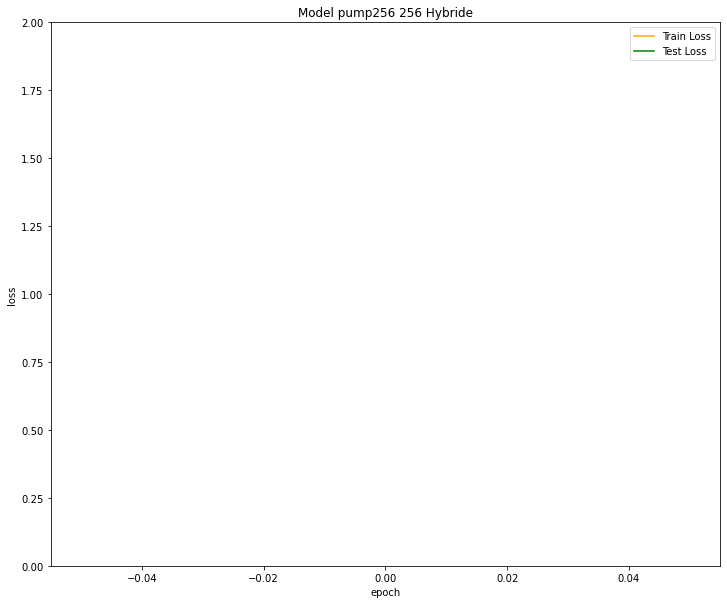

In [23]:
#plot de l'entrainement
plt.figure(figsize=(12,10))
plt.plot(history_IDclf4.history['loss'][5:],'orange' ,label = 'Train Loss',)
plt.plot(history_IDclf4.history['val_loss'][5:],'g', label = 'Test Loss')
plt.title('Model ' + machine+ str(dt) +" " + str(freq) +' Hybride')
plt.ylim((0,2))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend();

In [29]:
y_pred_ID = clf4.predict(X_test)
y_pred_ID = y_pred_ID.argmax(axis=1)

# Affichage des resultats

153 erreurs sur la classe normal soit 38.25 %  
256 erreurs sur la classe anomaly soit 56.14 %  
détails fichiers normaux
              precision    recall  f1-score   support

           0       0.74      0.14      0.24       100
           1       0.47      0.94      0.62       100
           2       0.81      0.75      0.78       100
           3       0.74      0.64      0.69       100

    accuracy                           0.62       400
   macro avg       0.69      0.62      0.58       400
weighted avg       0.69      0.62      0.58       400

détails fichiers anomaly
              precision    recall  f1-score   support

           0       0.52      0.22      0.31       143
           1       0.37      0.96      0.53       111
           2       0.68      0.17      0.27       100
           3       0.56      0.43      0.49       102

    accuracy                           0.44       456
   macro avg       0.53      0.45      0.40       456
weighted avg       0.53      0.44     

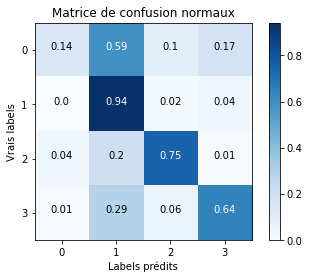

<Figure size 720x720 with 0 Axes>

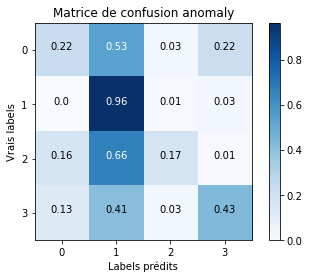

In [32]:
import itertools
err_normal = 0
err_anomaly = 0
for i in range(len(y_test_ID)):
    if (y_pred_ID[i] != y_test_ID[i]):
        if y_test_son[i] == 'normal':
           err_normal += 1  
        else:
           err_anomaly += 1
        
#print('nombre erreurs total: ', nbr_erreurs_total)
print('{} erreurs sur la classe normal soit {:.2f} %  '.format(err_normal, 100*err_normal/y_test_son[y_test_son=='normal'].shape[0]))
print('{} erreurs sur la classe anomaly soit {:.2f} %  '.format(err_anomaly, 100*err_anomaly/y_test_son[y_test_son=='anomaly'].shape[0]))

#résultats sur les fichiers normaux
print('détails fichiers normaux')
print(metrics.classification_report(y_test_ID[y_test_son=='normal'], y_pred_ID[y_test_son=='normal']))
crosstab=pd.crosstab(y_test_ID[y_test_son=='normal'], y_pred_ID[y_test_son=='normal'], rownames=['Classe réelle'], colnames=['Classe prédite'],normalize='index')

plt.figure()
plt.imshow(crosstab, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion normaux")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_train_ID)))
plt.xticks(tick_marks, np.unique(y_train_ID))
plt.yticks(tick_marks, np.unique(y_train_ID))

for i, j in itertools.product(range(crosstab.shape[0]), range(crosstab.shape[1])):
    plt.text(j, i, np.round(crosstab.iloc[i, j],2),
             horizontalalignment="center",
             color="white" if crosstab.iloc[i, j] > ( np.array(crosstab).max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')


#résultats sur les fichiers anomaly
print('détails fichiers anomaly')
print(metrics.classification_report(y_test_ID[y_test_son=='anomaly'], y_pred_ID[y_test_son=='anomaly']))
crosstab=pd.crosstab(y_test_ID[y_test_son=='anomaly'], y_pred_ID[y_test_son=='anomaly'], rownames=['Classe réelle'], colnames=['Classe prédite'],normalize='index')
plt.figure(figsize=(10,10))

plt.figure()
plt.imshow(crosstab, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion anomaly")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_train_ID)))
plt.xticks(tick_marks, np.unique(y_train_ID))
plt.yticks(tick_marks, np.unique(y_train_ID))

for i, j in itertools.product(range(crosstab.shape[0]), range(crosstab.shape[1])):
    plt.text(j, i, np.round(crosstab.iloc[i, j],2),
             horizontalalignment="center",
             color="white" if crosstab.iloc[i, j] > ( np.array(crosstab).max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits');

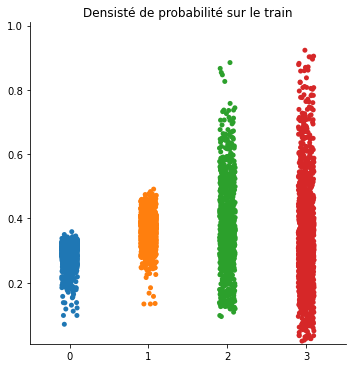

In [42]:
y_proba_train=clf4.predict(X_train)
y_train_dum=pd.get_dummies(y_train_ID)
y_proba_train=y_proba_train*y_train_dum
sns.catplot(data=y_proba_train)
plt.title("Densisté de probabilité sur le train")
plt.ylim((0.01,1.01));

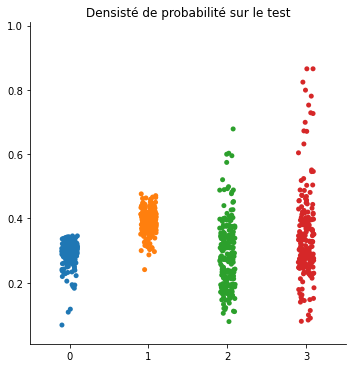

In [43]:
#sur le test
y_proba_test=clf4.predict(X_test)
y_test_dum=pd.get_dummies(y_test_ID)
y_proba_test=y_proba_test*y_test_dum
sns.catplot(data=y_proba_test)
plt.title("Densisté de probabilité sur le test")
plt.ylim((0.01,1.01));

In [47]:
#seuil par ID
y_proba_test=clf4.predict(X_test)
seuil_ID=np.array([0.2,0.3,0.2,0.2])
classes=['normal','anomaly']
y_seuil=y_test_dum*seuil_ID
y_desc=np.array(y_proba_test-y_seuil).sum(axis=1)
y_desc=np.where(y_desc<0,'anomaly','normal')

score AUC 50.00 %


<Figure size 720x720 with 0 Axes>

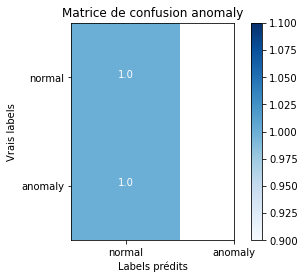

In [49]:
#calcul de l'AUC
fpr, tpr, thresholds = metrics.roc_curve(pd.DataFrame(y_test_son).replace(['normal','anomaly'],[normal_val,anomaly_val]), pd.DataFrame(y_desc).replace(['normal','anomaly'],[normal_val,anomaly_val]))
print('score AUC {:0.2f} %'.format(metrics.auc(fpr, tpr)*100))
#affichage de la crosstab
crosstab=pd.crosstab(y_test_son, y_desc, rownames=['Classe réelle'], colnames=['Classe prédite'],normalize='index')

plt.figure(figsize=(10,10))

plt.figure()
plt.imshow(crosstab, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion anomaly")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(crosstab.shape[0]), range(crosstab.shape[1])):
    plt.text(j, i, np.round(np.array(crosstab)[i, j],2),
             horizontalalignment="center",
             color="white" if np.array(crosstab)[i, j] > ( np.array(crosstab).max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits');